#### Assignment1: Dimensionality Reduction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# load dataset
from sklearn.datasets import load_breast_cancer 

# data split
from sklearn.model_selection import train_test_split

# data fitting
from sklearn.preprocessing import StandardScaler

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# test scores
from sklearn.metrics import accuracy_score, roc_auc_score

# PCA
from sklearn.decomposition import PCA

# ICA
from sklearn.decomposition import FastICA

# CCA
from sklearn.cross_decomposition import CCA

# t-SNE
from sklearn.manifold import TSNE
perplexities = [10, 30, 50]

random_state = 42

## Q1. L2 Regularization

In [ ]:
# 1. 데이터셋 로드
data = load_breast_cancer()

DATA = data.data
# print(X.shape) -> (569, 30): 569개 샘플, 30개의 특징

TARGET = data.target # 0 또는 1

features = data.feature_names

# 2. 데이터 분할
DATA_train, DATA_test, TARGET_train, TARGET_test = train_test_split(
    DATA, TARGET, test_size=0.2, random_state=random_state, stratify=TARGET
)

# 3. 데이터 표준화
scaler = StandardScaler()

DATA_train_scaled = scaler.fit_transform(DATA_train)
DATA_test_scaled = scaler.transform(DATA_test)

# 4. 모델 생성과 학습, 예측
model_L2 = LogisticRegression(
    penalty='l2', C=1.0, max_iter=5000,random_state=random_state
)

model_L2.fit(DATA_train_scaled, TARGET_train)

TARGET_predict = model_L2.predict(DATA_test_scaled)

TARGET_predict_proba = model_L2.predict_proba(DATA_test_scaled)[:, 1] # 인덱싱주의!!

# 5. 점수 출력
accuracy = accuracy_score(TARGET_test, TARGET_predict)
print("RESULT:")
print(f"TEST set accuracy: {accuracy:.3f}")

ROC_AUC = roc_auc_score(TARGET_test, TARGET_predict_proba)
print(f"ROC-AUC: {ROC_AUC:.3f}\n")

# 6. 계수 추출 및 절댓값이 가장 큰 5개 특성 찾기
coeffs_L2 = model_L2.coef_[0]
abs_coeffs = np.abs(coeffs_L2)

top_5_coeffs = np.argsort(abs_coeffs)[-5:][::-1]

print("TOP 5 coefficients:")

for idx, coeff in enumerate(top_5_coeffs):
    print(f"{idx+1}. {features[coeff]}: {coeffs_L2[coeff]:.3f}")


### Why L2 regularization is appropriate?

1. 계수의 제곱에 비례하는 페널티를 주기 때문에, overfitting을 방지할 수 있다는 장점이 있다. 특히 이 데이터의 경우 특징이 많기 때문에, 이 장점이 두드러진다.

2. LASSO와 다르게 Ridge의 경우, 계수를 0에 '가깝게' 만들기 때문에, 각 특성이 전부 유용하다고 생각하는 경우 더 좋다.

3. 최적화가 용이하고 학습이 안정적이라고 알려져 있다.


## Q2. L1 Regularization

In [ ]:
# 1. 모델 생성과 학습, 예측
model_L1 = LogisticRegression(
    penalty='l1',solver='saga',C=0.5,random_state=random_state, max_iter=5000
)

model_L1.fit(DATA_train_scaled, TARGET_train)

# 2. 계수 확인 및 nonzero coeff 찾기
coeffs_L1 = model_L1.coef_[0]

nonzero_coeffs_L1 = np.where(coeffs_L1 != 0)[0]

selected = len(nonzero_coeffs_L1)

# 절댓값 순서대로 정렬
nonzero_abs_coef = np.abs(coeffs_L1[nonzero_coeffs_L1])
sorted_order = np.argsort(nonzero_abs_coef)[::-1]

nonzero_coeffs_L1_sorted = nonzero_coeffs_L1[sorted_order]

print(f"Selected coefficients(L1): {selected}")

for idx, coeff in enumerate(nonzero_coeffs_L1_sorted):
    print(f"{idx+1}. {features[coeff]}: {coeffs_L1[coeff]:.3f}")

print("")
# 3. Ridge와의 비교
print("TOP 5 coefficients (L2)")
for idx, coeff in enumerate(top_5_coeffs):
    print(f"{idx+1}. {features[coeff]}: {coeffs_L2[coeff]:.3f}")

print("")

# 겹치는 것 확인(overlap)
print("Overlapping coefficients")
overlap = set(top_5_coeffs) & set(nonzero_coeffs_L1_sorted)

for idx in overlap:
    print(f" * {features[idx]}")

### Difference between L1 & L2

L1은 특성들에 대한 계수를 정확히 0으로 만들지만, L2는 0에 가깝게 만든다.

겹치는 상관 계수들은 두 방법이 결과 예측에 있어서 중요하다고 생각하는 공통 요소들이다. 반면 L1에는 없지만 L2에 있는 특성들은
이보다 덜 중요하다고 생각되는 특성들이다. 이들은 L1에선 그 계수가 0이 되었지만, L2에서는 여전히 작은 값으로 유지된다.

## Q3. PCA

In [ ]:
# 1. 전체 DATA를 표준화
scaler_PCA = StandardScaler()

DATA_scaled_PCA = scaler_PCA.fit_transform(DATA)

# 2. PCA 적용
pca = PCA(n_components=2, random_state=random_state)

DATA_pca = pca.fit_transform(DATA_scaled_PCA) # (569, 2)로 축소

# 3. PCA 산점도 출력
plt.figure()

malignant = (TARGET == 0)  
benign = (TARGET == 1)

plt.scatter(DATA_pca[malignant, 0], 
            DATA_pca[malignant, 1],
            label='malignant - 0')

plt.scatter(DATA_pca[benign, 0], 
            DATA_pca[benign, 1],
            label='benign - 1')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('PCA plot')
plt.legend()
plt.show()

# 4. explained variance ratio, cumulative variance 출력
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var = explained_var_ratio.sum() # 둘의 합

print(f"Explained variance ratio: PC1 = {explained_var_ratio[0]:.3f}, PC2 = {explained_var_ratio[1]:.3f}")
print(f"Cumulative explained variance = {cumulative_var:.3f}\n")

# 5. L2 regularization에서 뽑은, 가장 중요한 2개를 골라 Plot
top_2_coeffs = top_5_coeffs[:2]
top_2 = features[top_2_coeffs]

# Q1에서는 train, test를 나눠 scaler를 적용하였기 때문에, 따로 scaler를 적용해줘야 한다
scaler_top_2 = StandardScaler()

DATA_top_2 = DATA[:, top_2_coeffs] # (569: 2)

DATA_top_2_scaled = scaler_top_2.fit_transform(DATA_top_2)

plt.scatter(DATA_top_2_scaled[malignant, 0], 
            DATA_top_2_scaled[malignant, 1],
            label='Malignant - 0')

plt.scatter(DATA_top_2_scaled[benign, 0], 
            DATA_top_2_scaled[benign, 1],
            label='Benign - 1')

plt.xlabel(top_2[0])
plt.ylabel(top_2[1])

plt.title('Q1 (L2) Plot - top 2 features only')
plt.legend()
plt.show()


### Difference

PCA는 분산이 최대가 되는 방향으로 축을 만들지만, L2 Regularization에서는 기존에 절댓값이 가장 큰 2개의 특성 축을 그대로 사용한다.

전자는 여러 특성축이 결합한 형태의 2가지 축이다.
후자는 선택한 2개의 단일 특성축에 따른 직접적 분포를 보여준다.

## Q4. ICA

In [ ]:
# 1. ICA 적용
ica = FastICA(n_components=2, random_state=random_state)

DATA_ica = ica.fit_transform(DATA_scaled_PCA) # 전체 데이터 scale 한 것으로, 재활용함.  

# 2. ICA 산점도 출력
plt.figure()

plt.scatter(DATA_ica[TARGET == 0, 0], 
            DATA_ica[TARGET == 0, 1],
            label='Malignant - 0')

plt.scatter(DATA_ica[TARGET == 1, 0], 
            DATA_ica[TARGET == 1, 1],
            label='Benign - 1')

plt.xlabel("independent component - 1")
plt.ylabel("independent component - 2 ")

plt.title("ICA")
plt.legend()
plt.show()


### Difference between PCA & ICA

둘 다 데이터의 차원을 축소하는 기술이다.

PCA는 데이터의 분산을 최대화하는 방향으로, 기존 특성을 결합한 축을 찾는다. 반면 ICA는 "통계적으로' 독립적인 성분으로 데이터를 분리한다.

아래 그림이 PCA와 ICA의 차이를 잘 나타낸다고 할 수 있다.

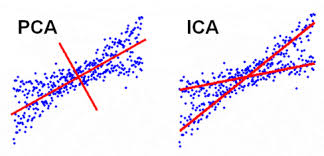

## Q5. CCA

In [ ]:
# 1. 데이터를 두 그룹으로 분리
View_A_index = [index for index, feature in enumerate(features) if feature.startswith('mean')]
View_A = DATA[:, View_A_index]

scaler_A = StandardScaler()
View_A_scaled = scaler_A.fit_transform(View_A)

View_B_index = [index for index, feature in enumerate(features) if feature.startswith('worst')]
View_B = DATA[:, View_B_index]

scaler_B = StandardScaler()
View_B_scaled = scaler_B.fit_transform(View_B)

# 2. CCA 적용
cca = CCA(n_components=2) # no random state: closed form!
View_A_cca, View_B_cca = cca.fit_transform(View_A_scaled, View_B_scaled)

# 3. canonical correlation value 계산
corrs = [np.corrcoef(View_A_cca[:, index], View_B_cca[:, index])[0, 1] for index in range(2)] # 첫 두개 쌍

print(f"canonical correlation 1: {corrs[0]:.3f}")
print(f"canonical correlation 2: {corrs[1]:.3f}")

print("")

# 4. 첫 canonical pair에서, 3개의 특성 추출
'''
x_weights_ndarray of shape (n_features, n_components)
The left singular vectors of the cross-covariance matrices of each iteration.

y_weights_ndarray of shape (n_targets, n_components)
The right singular vectors of the cross-covariance matrices of each iteration.
'''
weights_A = np.abs(cca.x_weights_[:, 0])
top_3_A_index = np.argsort(weights_A)[-3:][::-1]

weights_B = np.abs(cca.y_weights_[:, 0])
top_3_B_index = np.argsort(weights_B)[-3:][::-1]

print("Top 3 contributing features\n")

print(" * View_A (mean_*):")
for index in top_3_A_index:
    print(f"{features[View_A_index[index]]}: {cca.x_weights_[index, 0]:.3f}")

print("")

print(" * View B (worst_*):")
for index in top_3_B_index:
    print(f"{features[View_B_index[index]]}: {cca.y_weights_[index, 0]:.3f}")


### Brief interpretation

데이터를 mean이 앞에 붙어있는 데이터 | worst가 앞에 붙어있는 데이터 두 그룹으로 나누어, 정준 상관계수를 분석하였다.

첫 번째 canonical correlatio은 "두 변수 그룹 간의 관계를 가장 강력하게 설명하는 대표 변수 쌍 끼리의 상관계수"이다. 현재 1에 매우 가까운 값을 나타내고 있으므로, 매우 강한 상관관계를 가지고 있다고 분석할 수 있다.

두 번째 canonical correlation 역시 0.9를 넘기 때문에, 첫 번째와 관련되지 않은 다른 특성끼리도 서로를 잘 설명한다고 할 수 있다.

## Q6. t-SNE

In [ ]:
total_fig, subplot = plt.subplots(1, len(perplexities), figsize = (20, 5))

# 전체 데이터 사용
scaler_t_SNE = StandardScaler()
DATA_scaled = scaler_t_SNE.fit_transform(DATA)

for index, perplexity in enumerate(perplexities):

    # 1. t_sne 모델 학습
    t_sne = TSNE(n_components=2, perplexity = perplexity, n_iter=1000, random_state = random_state)
    DATA_tsne = t_sne.fit_transform(DATA_scaled) 

    # 2. plotting (side - by - side)
    scatter = subplot[index].scatter(DATA_tsne[:, 0], DATA_tsne[:, 1], c = TARGET)

    subplot[index].set_xlabel('t-SNE component 1')
    subplot[index].set_ylabel('t-SNE component 2')

    subplot[index].set_title(f'perplexity = {perplexity}')
    subplot[index].legend(handles=scatter.legend_elements()[0], labels=['malignant', 'benign'])

plt.show()

### Short discussion

확실히 perplexity 값이 더 작을 때, 더 세분화되어 군집을 이루는 모습을 볼 수 있다. 값이 증가할수록 더 큰 군집이 강조되어 나타난다. 이들 사이에서 적당한 값을 찾는 것이 중요해 보인다. 참고로, t-sne의 경우, 군집화 및 시각화시키기 위하여 기존 데이터를 변형한다. 또, 실행할 때마다 그 결과가 달라질 수 있다. 이전 방식들과 동일하게 차원 축소에 사용된다는 점은 동일하지만, 실행 시간이 오래 걸린다는 단점이 존재한다.
